In [1]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator
import yfinance as yf

C:\Users\krzys\AppData\Local\Temp\ipykernel_2616\2623612840.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


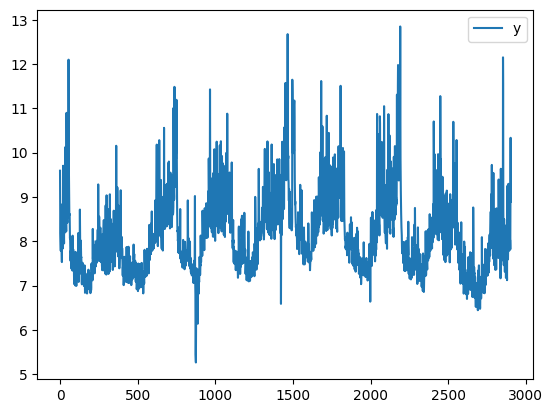

In [3]:
df.plot()
plt.show()

In [4]:
df.rename(columns={"ds": "date", "y": "value"}, inplace=True)
df.head()
df['date'] = pd.to_datetime(df['date'])
df['value'] = df['value'].astype('float32')

df.set_index("date", inplace=True)
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='d')

df = df.reindex(full_index)

df.fillna(method='ffill', inplace=True)
df.head()

C:\Users\krzys\AppData\Local\Temp\ipykernel_2616\1352901458.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,value
2007-12-10,9.590761
2007-12-11,8.519590
2007-12-12,8.183677
2007-12-13,8.072468
2007-12-14,7.893572


In [5]:
train_end = round(len(df) * 0.7)
valid_end = round(len(df) * 0.9)

train = PandasDataset(df[:train_end], freq="d", target="value")
valid = PandasDataset(df[train_end:valid_end], freq="d", target="value")
test = PandasDataset(df[valid_end:], freq="d", target="value")

In [6]:
#predict next week
prediction_length = 7
context_length = prediction_length * 3
num_samples = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64

In [7]:
import os
os.environ['TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD'] = '1'

In [8]:
ckpt = torch.load('lag-llama.ckpt', map_location=device)
estimator_args = ckpt['hyper_parameters']['model_kwargs']

zs_estimator = LagLlamaEstimator(
    ckpt_path='lag-llama.ckpt',
    prediction_length=prediction_length,
    context_length=context_length,
    device=device,

    #estimator args
    input_size=estimator_args['input_size'],
    n_layer=estimator_args['n_layer'],
    n_embd_per_head=estimator_args['n_embd_per_head'],
    n_head=estimator_args['n_head'],
    scaling=estimator_args['scaling'],
    time_feat=estimator_args['time_feat'],

    nonnegative_pred_samples=True,

    rope_scaling={
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    },
    batch_size=batch_size,
    num_parallel_samples=num_samples
)

zs_predictor = zs_estimator.create_predictor(zs_estimator.create_transformation(), zs_estimator.create_lightning_module())

C:\Users\krzys\AppData\Local\Temp\ipykernel_2616\2216616441.py:1: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  ckpt = torch.load('lag-llama.ckpt', map_location=device)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.


In [9]:
date_list = pd.date_range(df[valid_end:].index[60], periods=9, freq="30d").tolist()
print(date_list)
zs_forecasts = []
zs_tss = []


for d in date_list:
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=PandasDataset(df[:d], freq="d", target="value"),
        predictor=zs_predictor,
        num_samples=num_samples
    )

    zs_forecasts.append(list(forecast_it))
    zs_tss.append(list(ts_it))

[Timestamp('2015-05-30 00:00:00'), Timestamp('2015-06-29 00:00:00'), Timestamp('2015-07-29 00:00:00'), Timestamp('2015-08-28 00:00:00'), Timestamp('2015-09-27 00:00:00'), Timestamp('2015-10-27 00:00:00'), Timestamp('2015-11-26 00:00:00'), Timestamp('2015-12-26 00:00:00'), Timestamp('2016-01-25 00:00:00')]


In [10]:
evaluator = Evaluator()
zs_a_metrics = [] 
zs_t_metrics = []

for (t, s) in zip(zs_tss, zs_forecasts):
    agg_metrics, ts_metrics = evaluator(t, s)
    zs_a_metrics.append(agg_metrics)
    zs_t_metrics.append(ts_metrics)

Running evaluation: 1it [00:00, 110.80it/s]
Running evaluation: 1it [00:00, 142.40it/s]
Running evaluation: 1it [00:00, 142.87it/s]
Running evaluation: 1it [00:00, 165.98it/s]
Running evaluation: 1it [00:00, 165.94it/s]
Running evaluation: 1it [00:00, 142.86it/s]
Running evaluation: 1it [00:00, 166.73it/s]
Running evaluation: 1it [00:00, 41.66it/s]
Running evaluation: 1it [00:00, 90.94it/s]


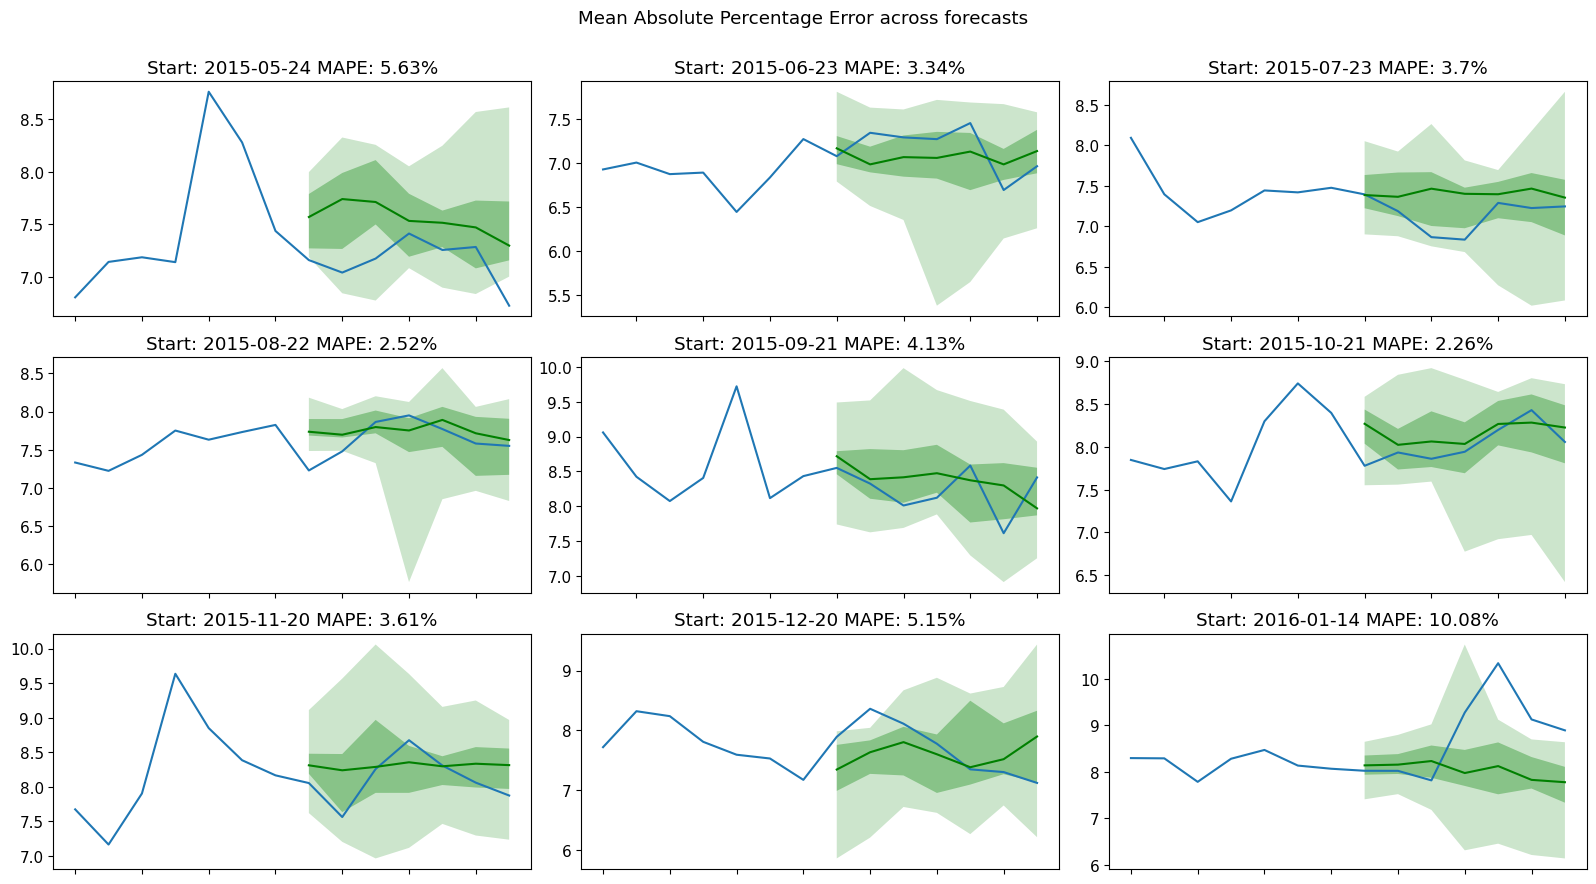

Average MAPE: 4.49


In [11]:
plt.figure(figsize=(16, 9))

plt.rcParams.update({'font.size': 11})

smapes = []

for idx in range(len(zs_forecasts)):
    ax = plt.subplot(3, 3, idx+1)
    t = zs_tss[idx][0][zs_forecasts[idx][0].start_date.to_timestamp() - pd.Timedelta(days=7):]

    smape = float(f'{zs_t_metrics[idx]["MAPE"][0]:.4f}') * 100.0
    smape = float(f'{smape:.2f}')
    smapes.append(smape)
    ax.set_title("Start: " + str(zs_t_metrics[idx]["forecast_start"][0]) + " MAPE: " + str(smape) + "%")
    plt.plot(t.index.to_timestamp(), t[0])
    ax.set_xticklabels([])

    zs_forecasts[idx][0].plot(color='g')

plt.gcf().tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Mean Absolute Percentage Error across forecasts")
plt.show()
print(f'Average MAPE: {sum(smapes) / len(smapes):.2f}')

In [12]:
from pathlib import Path

best_score = float("inf")
evaluator = Evaluator()

def objective(trial):
    global best_score

    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    base_args = ckpt["hyper_parameters"]["model_kwargs"]

    trial_args = {
        "input_size": base_args["input_size"],  # or tune if you want
        "n_layer": trial.suggest_int("n_layer", 2, 6),
        "n_embd_per_head": base_args["n_embd_per_head"],  # or make tunable
        "n_head": base_args["n_head"],  # usually fixed
        "scaling": trial.suggest_float("scaling", 0.5, 2.0),
        "time_feat": trial.suggest_categorical("time_feat", [True, False]),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",  
        prediction_length=prediction_length,
        context_length=context_length,
        device=device,
        nonnegative_pred_samples=True,
        num_parallel_samples=num_samples,
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / context_length),
        },
        **trial_args
    )

    try:
        predictor = estimator.train(
            train,
            valid,
            cache_data=True,
            shuffle_buffer_length=1000,
            max_epochs=100,  # maybe increase this
            patience=5,
            lr_scheduler="cosine_annealing",
            learning_rate=trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
            weight_decay=trial.suggest_float("weight_decay", 1e-4, 1e-2, log=True),
        )

        forecast_it, ts_it = make_evaluation_predictions(
            dataset=valid,
            predictor=predictor,
            num_samples=num_samples
        )

        agg_metrics, _ = evaluator(ts_it, forecast_it)
        mape = agg_metrics["MAPE"]

        if mape < best_score:
            best_score = mape
            print(f"New best MAPE: {mape:.4f}, saving model...")
            
            Path("best_model").mkdir(parents=True, exist_ok=True)
            predictor.serialize(Path("best_model"))

        return mape
    
    except Exception as e:
        print(f"Trial failed: {e}")
        return float("inf")

In [15]:
from gluonts.model.predictor import Predictor

finetuned_predictor = Predictor.deserialize(Path("best_model"))

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\torch\model\predictor.py:117: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  state_dict = torch.load(


In [16]:
date_list = pd.date_range(df[valid_end:].index[0], periods=9, freq="30d").tolist()

finetune_forecasts = []
finetune_tss = []

for d in date_list:
    print(d)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=PandasDataset(df[:d], freq="1d", target="value"),
        predictor=finetuned_predictor,
        num_samples=num_samples
    )
    finetune_forecasts.append(list(forecast_it))
    finetune_tss.append(list(ts_it))

2015-03-31 00:00:00
2015-04-30 00:00:00
2015-05-30 00:00:00
2015-06-29 00:00:00
2015-07-29 00:00:00
2015-08-28 00:00:00
2015-09-27 00:00:00
2015-10-27 00:00:00
2015-11-26 00:00:00


In [17]:
evaluator = Evaluator()
finetune_a_metrics = [] 
finetune_t_metrics  = []

for (t, s) in zip(finetune_tss, finetune_forecasts):
    agg_metrics, ts_metrics = evaluator(t, s)
    finetune_a_metrics.append(agg_metrics)
    finetune_t_metrics .append(ts_metrics)

Running evaluation: 1it [00:00, 111.13it/s]
Running evaluation: 1it [00:00, 125.00it/s]
Running evaluation: 1it [00:00, 125.05it/s]
Running evaluation: 1it [00:00, 142.36it/s]
Running evaluation: 1it [00:00, 142.37it/s]
Running evaluation: 1it [00:00, 142.32it/s]
Running evaluation: 1it [00:00, 110.73it/s]
Running evaluation: 1it [00:00, 142.30it/s]
Running evaluation: 1it [00:00, 124.62it/s]


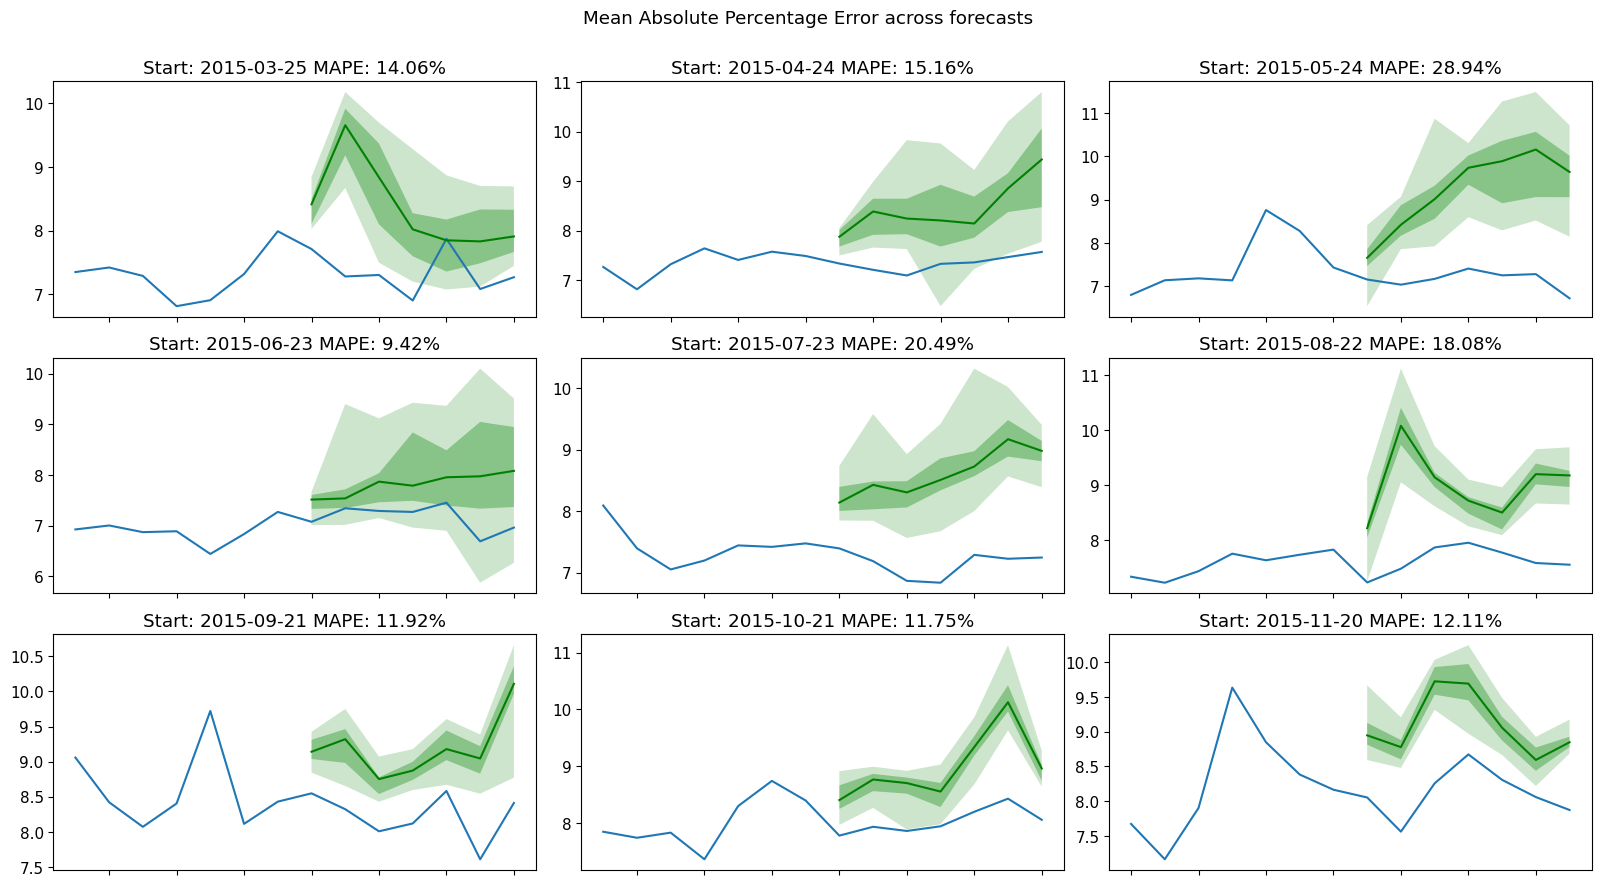

Average MAPE: 15.77


In [18]:
plt.figure(figsize=(16, 9))

plt.rcParams.update({'font.size': 11})
smapes = []

for idx in range(len(finetune_forecasts)):
    ax = plt.subplot(3, 3, idx+1)
    t = finetune_tss[idx][0][finetune_forecasts[idx][0].start_date.to_timestamp() - pd.Timedelta(days=7):]

    smape = float(f'{finetune_t_metrics[idx]["MAPE"][0]:.4f}') * 100.0
    smape = float(f'{smape:.2f}')
    smapes.append(smape)
    ax.set_title("Start: " + str(finetune_t_metrics[idx]["forecast_start"][0]) + " MAPE: " + str(smape) + "%")
    plt.plot(t.index.to_timestamp(), t[0])
    ax.set_xticklabels([])

    finetune_forecasts[idx][0].plot(color='g')

plt.gcf().tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Mean Absolute Percentage Error across forecasts")
plt.show()
print(f'Average MAPE: {sum(smapes)/len(smapes):.2f}')

In [21]:
ckpt = torch.load("lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

finetune_estimator = LagLlamaEstimator(
    ckpt_path='lag-llama.ckpt',
    prediction_length=prediction_length,
    context_length=context_length,
    device=device,

    #estimator args
    input_size=estimator_args['input_size'],
    n_layer=estimator_args['n_layer'],
    n_embd_per_head=estimator_args['n_embd_per_head'],
    n_head=estimator_args['n_head'],
    scaling=estimator_args['scaling'],
    time_feat=estimator_args['time_feat'],

    nonnegative_pred_samples=True,

    rope_scaling={
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    },
    batch_size=batch_size,
    num_parallel_samples=num_samples
)

# Fine-tune with early stopping (patience=5)
finetuned_predictor = finetune_estimator.train(
    train,
    valid,
    cache_data=True,
    shuffle_buffer_length=1000,
    max_epochs=50,
    patience=5,  # Early stopping if no improvement for 5 epochs
    lr_scheduler="cosine_annealing",
    learning_rate=1e-4,  # Adjust as needed
    weight_decay=1e-4    # Adjust as needed
)

C:\Users\krzys\AppData\Local\Temp\ipykernel_2616\1451857824.py:1: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  ckpt = torch.load("lag-llama.ckpt", map_location=device)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflict

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 0.35075 (best 0.35075), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_64\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' reached 0.26259 (best 0.26259), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_64\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' reached 0.22960 (best 0.22960), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_64\\checkpoints\\epoch=8-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 2100: 'val_loss' reached 0.21063 (best 0.21063), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_64\\checkpoints\\epoch=41-step=2100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 2150: 'val_loss' reached 0.19763 (best 0.19763), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_64\\checkpoints\\epoch=42-step=2150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 2300: 'val_loss' reached 0.18091 (best 0.18091), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_64\\checkpoints\\epoch=45-step=2300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.


In [22]:
date_list = pd.date_range(df[valid_end:].index[0], periods=9, freq="30d").tolist()

finetune_forecasts = []
finetune_tss = []

for d in date_list:
    print(d)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=PandasDataset(df[:d], freq="1d", target="value"),
        predictor=finetuned_predictor,
        num_samples=num_samples
    )
    finetune_forecasts.append(list(forecast_it))
    finetune_tss.append(list(ts_it))

2015-03-31 00:00:00
2015-04-30 00:00:00
2015-05-30 00:00:00
2015-06-29 00:00:00
2015-07-29 00:00:00
2015-08-28 00:00:00
2015-09-27 00:00:00
2015-10-27 00:00:00
2015-11-26 00:00:00


In [23]:
evaluator = Evaluator()
finetune_a_metrics = [] 
finetune_t_metrics  = []

for (t, s) in zip(finetune_tss, finetune_forecasts):
    agg_metrics, ts_metrics = evaluator(t, s)
    finetune_a_metrics.append(agg_metrics)
    finetune_t_metrics .append(ts_metrics)

Running evaluation: 1it [00:00, 125.00it/s]
Running evaluation: 1it [00:00, 124.98it/s]
Running evaluation: 1it [00:00, 125.14it/s]
Running evaluation: 1it [00:00, 125.02it/s]
Running evaluation: 1it [00:00, 111.12it/s]
Running evaluation: 1it [00:00, 124.54it/s]
Running evaluation: 1it [00:00, 124.62it/s]
Running evaluation: 1it [00:00, 125.03it/s]
Running evaluation: 1it [00:00, 125.05it/s]


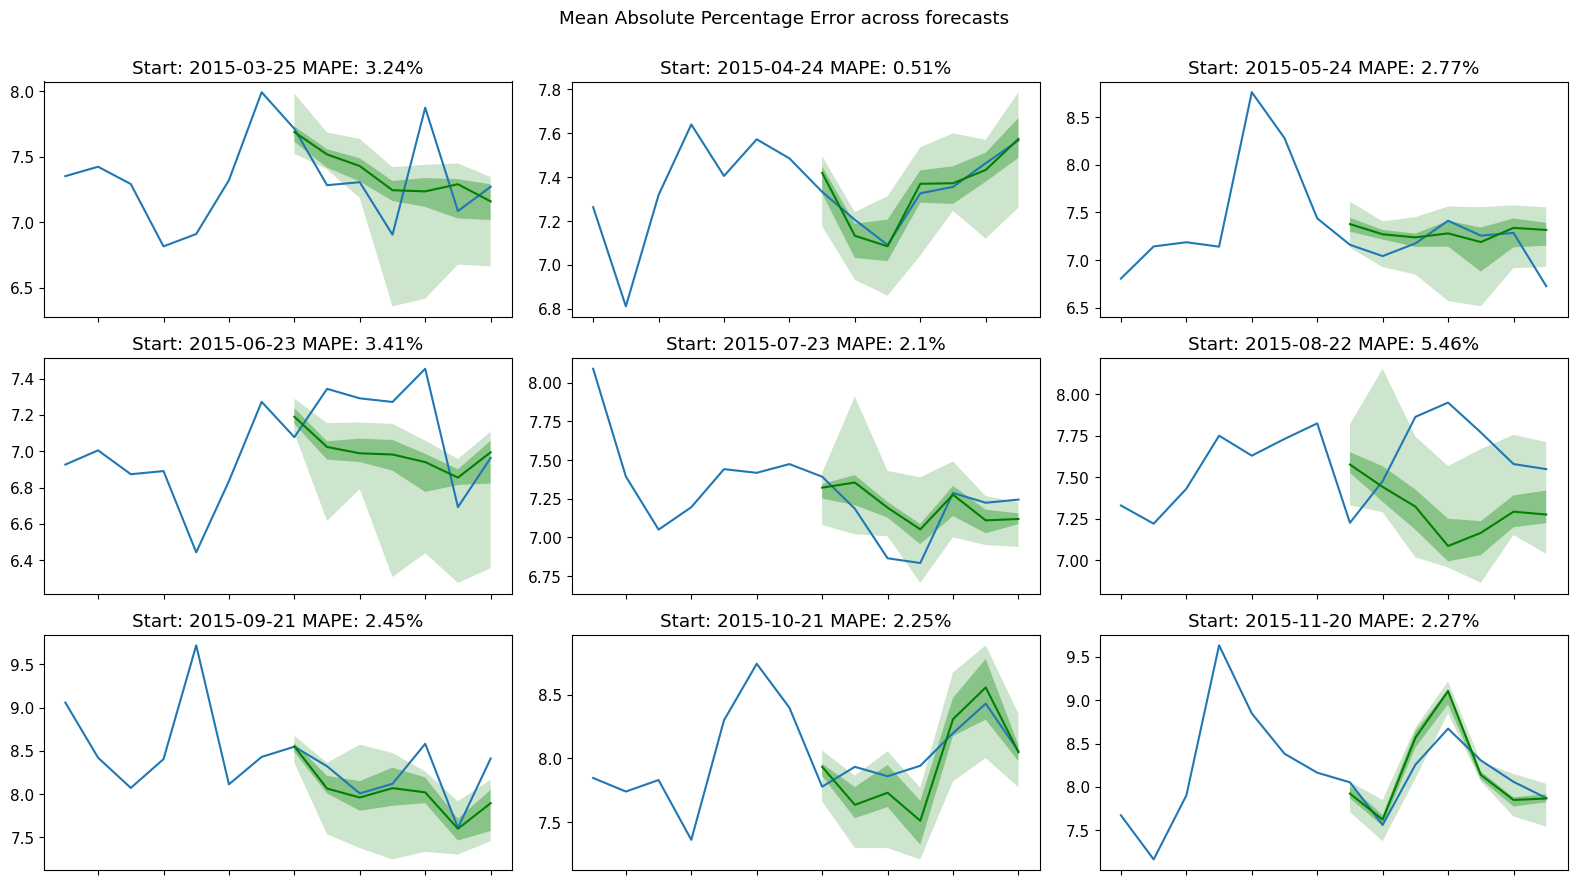

Average MAPE: 2.72


In [24]:
plt.figure(figsize=(16, 9))

plt.rcParams.update({'font.size': 11})
smapes = []

for idx in range(len(finetune_forecasts)):
    ax = plt.subplot(3, 3, idx+1)
    t = finetune_tss[idx][0][finetune_forecasts[idx][0].start_date.to_timestamp() - pd.Timedelta(days=7):]

    smape = float(f'{finetune_t_metrics[idx]["MAPE"][0]:.4f}') * 100.0
    smape = float(f'{smape:.2f}')
    smapes.append(smape)
    ax.set_title("Start: " + str(finetune_t_metrics[idx]["forecast_start"][0]) + " MAPE: " + str(smape) + "%")
    plt.plot(t.index.to_timestamp(), t[0])
    ax.set_xticklabels([])

    finetune_forecasts[idx][0].plot(color='g')

plt.gcf().tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Mean Absolute Percentage Error across forecasts")
plt.show()
print(f'Average MAPE: {sum(smapes)/len(smapes):.2f}')

## SCORES

Initial model MAPE: 4.49
Optuna model MAPE: 15.77 (found model was a lot smaller)
Adittionally trained original MAPE: 2.72